# Importation des librairies

In [2]:
import pandas as pd
import numpy as np
import json
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

import geopandas as gpd
import contextily as ctx
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Importation du dataset d'avril

In [3]:
data = pd.read_csv('data/uber-raw-data-apr14.csv')
data.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


# Informations sur le dataset

In [4]:
data.describe(include='all')

,Date/Time,Lat,Lon,Base
count,564516,564516.000000,564516.000000,564516
unique,41999,NaN,NaN,5
top,4/7/2014 20:21:00,NaN,NaN,B02682
freq,97,NaN,NaN,227808
mean,NaN,40.740005,-73.976817,NaN
std,NaN,0.036083,0.050426,NaN
min,NaN,40.072900,-74.773300,NaN
25%,NaN,40.722500,-73.997700,NaN
50%,NaN,40.742500,-73.984800,NaN
75%,NaN,40.760700,-73.970000,NaN


In [5]:
data.isnull().any()

Date/Time    False
Lat          False
Lon          False
Base         False
dtype: bool

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  564516 non-null  object 
 1   Lat        564516 non-null  float64
 2   Lon        564516 non-null  float64
 3   Base       564516 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.2+ MB


In [7]:
print('Nombre de lignes: ', data.shape[0])
print('Nombre de colonnes: ', data.shape[1])

Nombre de lignes:  564516
Nombre de colonnes:  4


# Preprocessing

In [8]:
# Renommer la variable Date/Time.
data.rename(columns={'Date/Time': 'datetime'}, inplace=True)
data.head()

,datetime,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [9]:
# Décomposer la variable datetime.
data['datetime'] = pd.to_datetime(data['datetime'])
data['week_day'] = data['datetime'].dt.weekday
data['hour'] = data['datetime'].dt.hour
data.head()

,datetime,Lat,Lon,Base,week_day,hour
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1,0


In [10]:
# Supprmer les outliers (ici on considère tout ce qui est a  +/-3 ecarts types de la moyenne).
print(data.shape)

# Latitude.
mask = ((data['Lat'] <= data['Lat'].mean()+3*data['Lat'].std()) &
        (data['Lat'] >= data['Lat'].mean()-3*data['Lat'].std()))

data = data.loc[mask,:]
print(data.shape)

# Longitude.
mask = ((data['Lon'] <= data['Lon'].mean()+3*data['Lon'].std()) &
        (data['Lon'] >= data['Lon'].mean()-3*data['Lon'].std()))

data = data.loc[mask,:]
print(data.shape)

(564516, 6)
(557824, 6)
(538837, 6)


# Test sur une heure : de 8h à 9h le lundi

In [11]:
# Filtrer pour ne garder que les données du lundi de 8h à 9h.
monday_8 = (data['week_day'] == 0) & (data['hour'] == 8)
data_monday_8 = data.loc[monday_8,:]
print(data_monday_8.shape)
data_monday_8.head()

(3018, 6)


,datetime,Lat,Lon,Base,week_day,hour
7947,2014-04-07 08:00:00,40.7205,-73.9968,B02512,0,8
7948,2014-04-07 08:01:00,40.7747,-73.9901,B02512,0,8
7949,2014-04-07 08:01:00,40.7741,-73.8723,B02512,0,8
7950,2014-04-07 08:02:00,40.7354,-74.0039,B02512,0,8
7951,2014-04-07 08:04:00,40.7307,-73.9852,B02512,0,8


In [12]:
# Supprimer les variables non voulues pour le clustering.
data_monday_8 = data_monday_8.drop(['datetime', 'Base', 'week_day', 'hour'], axis=1)

# Standardisation.
scaler = StandardScaler()
monday_8_scaled = scaler.fit_transform(data_monday_8)

monday_8_scaled[:5]

array([[-0.76134256, -0.68956964],
       [ 1.02017615, -0.48667731],
       [ 1.00045454,  3.08059387],
       [-0.27158926, -0.90457495],
       [-0.4260752 , -0.33829336]])

## Avec KMeans:

In [13]:
wcss = []
k = []

# Tester KMeans avec 1 à 10 clusters et calculer son inertie.
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(monday_8_scaled)
    wcss.append(kmeans.inertia_)
    k.append(i)

# Enregistrer les résultats dans des dataframes.
wcss_df = pd.DataFrame(wcss)
k_serie = pd.Series(k)

# Tracer l'inertie pour chaque nombre de clusters.
fig = px.line(
    wcss_df,
    x=k_serie,
    y=wcss_df.iloc[:,-1]
)

fig.update_layout(
    yaxis_title='Inertia',
    xaxis_title='Clusters',
    title='Inertie par cluster'
)

fig.show()

Note: 
On veut des clusters dont l'inertie ne chute pas drastiquement en passant au nombre de clusters suivant. Et qui, par contre ont une inertie bien plus basse que le nombre de clusters précédents. Ici, on retiendra donc les clusters 4, 5, 6, 7 et 8.

In [14]:
k_cluster = [4, 5, 6, 7, 8]

In [15]:
sil = []
k = []

# Tester KMeans avec 2 à 10 clusters et calculer son score de silhouette.
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(monday_8_scaled)
    sil.append(silhouette_score(monday_8_scaled, kmeans.predict(monday_8_scaled)))
    k.append(i)

# Enregistrer les résultats dans un dataframe.
cluster_scores = pd.DataFrame(sil)

# Tracer le graphe d'évolution du score de silhouette en fonction du nombre de clusters.
fig = px.bar(data_frame=cluster_scores, x=k, y=cluster_scores.iloc[:,-1])

fig.update_layout(
    xaxis_title='Nombres de clusters',
    yaxis_title='Silhouette score',
    title='Silhouette score par cluster'
)

fig.show()

Note:
On observe que le nombre de clusters obtenant le score de silhouette maximal est 2. Toutefois, nous voulons nous concentrer sur les nombres de clusters dont l'inertie était plus adéquate. Et parmi ces nombres de clusters, c'est le 4 qui obtient le meilleur score de silhouette.

In [16]:
# Garder le nombre k de cluster parmi k_cluster qui a le meilleur score de silhouette.
k_cluster = [k for k in k_cluster if cluster_scores.loc[k,0]==max(cluster_scores.loc[k_cluster, 0])]
k_cluster

[4]

In [17]:
# Instancier KMeans avec 4 clusters.
kmeans = KMeans(n_clusters=4, random_state=0)

# Calculer les clusters sur les données du lundi entre 8h et 9h.
kmeans.fit(monday_8_scaled)

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,0
,copy_x,True
,algorithm,'lloyd'


In [18]:
# Assigner un cluster à chaque pickup (chaque ligne).
data_monday_8['cluster'] = kmeans.labels_

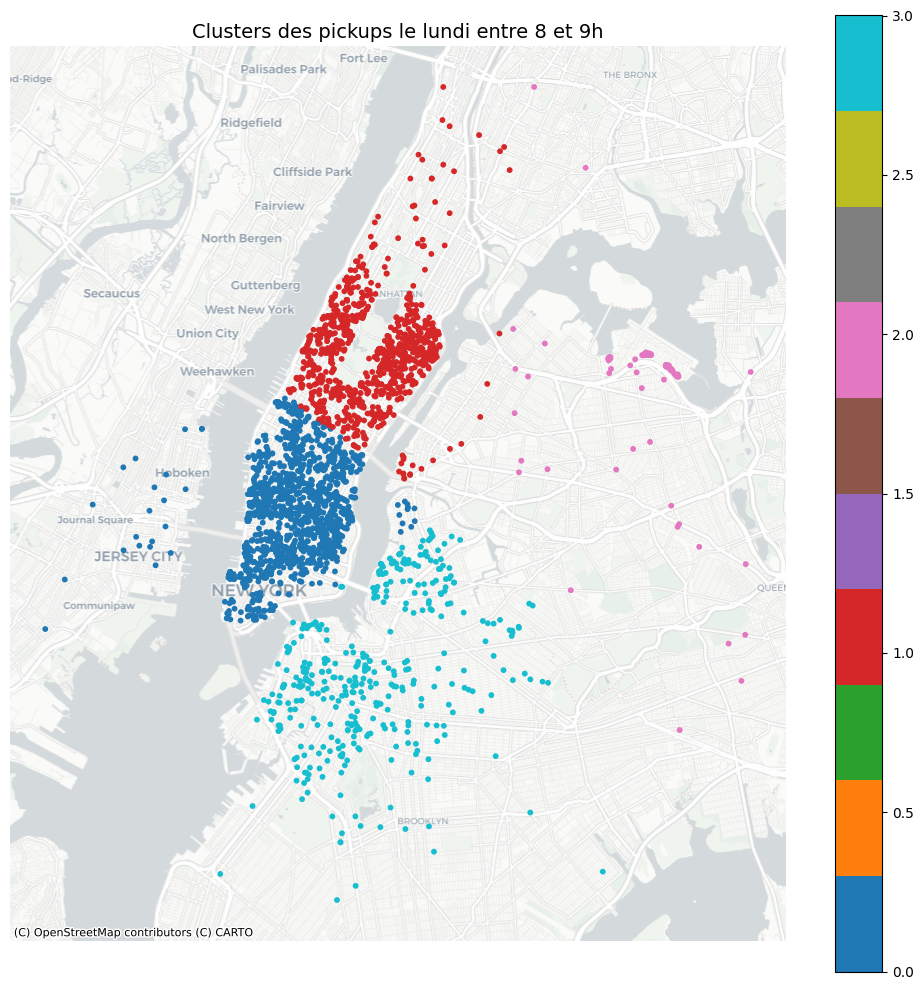

In [19]:
# Création d'un GeoDataFrame permettant les opérations spatiales.
gdf = gpd.GeoDataFrame(
    data_monday_8,
    geometry=gpd.points_from_xy(data_monday_8['Lon'], data_monday_8['Lat']),
    crs='EPSG:4326'  # Système de coordonnées WGS84 (GPS).
)

# Passer les données GPS en mètres.
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

# Afficher les clusters sur une carte.
gdf.plot(
    ax=ax,
    column='cluster',
    cmap='tab10',
    markersize=10,
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("Clusters des pickups le lundi entre 8 et 9h", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Avec DBscan:

In [20]:
# Instancier DBscan.
dbscan = DBSCAN(eps=0.2, min_samples=12, algorithm='brute')

# Calculer les clusters.
dbscan.fit(monday_8_scaled)

,eps,0.2
,min_samples,12
,metric,'euclidean'
,metric_params,None
,algorithm,'brute'
,leaf_size,30
,p,None
,n_jobs,None


In [21]:
# Assigner un cluster à chaque pickup.
data_monday_8['cluster'] = dbscan.labels_

In [22]:
# Ne garder que les pickups appartenant à un cluster.
monday_8_non_outliers = data_monday_8[data_monday_8['cluster']!=-1]

# Afficher les clusters sur une carte.
fig = px.scatter_mapbox(
    monday_8_non_outliers,
    lat="Lat",
    lon="Lon",
    color="cluster",
    hover_name="cluster",
    zoom=11,
    height=800
)

fig.update_layout(
    mapbox_style="carto-positron",
    title_text="Clusters des pickups le lundi entre 8 et 9h",
    title_x=0.5,
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.show()
monday_8_non_outliers['cluster'].unique()

C:\Users\Julien Rouillard\AppData\Local\Temp\ipykernel_19540\2934761597.py:5: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



array([0, 1, 2, 3, 4, 5])

On va préférer DBscan car il élimine les outliers, donc rend plus lisibles les clusters, et le découpage des clusters est plus cohérent avec la réalité (un unique cluster pour toute la partie de la ville entourée de rivières).

De plus, il semble compliquer de déterminer le nombre de clusters nécessaires pour un dataset, donc pour généraliser la méthode, on préfèrera partir sur DBscan.

# Généraliser

## Importer tous les dataset et les réunir

In [23]:
data = pd.DataFrame()

# Liste des mois dont on possède les données.
months = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']

# Concaténer les données de chaque mois en un seul dataset.
for month in months:
    data = pd.concat([data, pd.read_csv('data/uber-raw-data-{}14.csv'.format(month))])

## Informations sur le dataset

In [24]:
data.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [25]:
print('Nombre de lignes: ', data.shape[0])

Nombre de lignes:  4534327


In [26]:
data.describe(include='all')

,Date/Time,Lat,Lon,Base
count,4534327,4.534327e+06,4.534327e+06,4534327
unique,260093,NaN,NaN,5
top,4/7/2014 20:21:00,NaN,NaN,B02617
freq,97,NaN,NaN,1458853
mean,NaN,4.073926e+01,-7.397302e+01,NaN
std,NaN,3.994991e-02,5.726670e-02,NaN
min,NaN,3.965690e+01,-7.492900e+01,NaN
25%,NaN,4.072110e+01,-7.399650e+01,NaN
50%,NaN,4.074220e+01,-7.398340e+01,NaN
75%,NaN,4.076100e+01,-7.396530e+01,NaN


In [27]:
data.isnull().any()

Date/Time    False
Lat          False
Lon          False
Base         False
dtype: bool

## Preprocessing

In [28]:
# Renommer la colonnne Date/Time.
data.rename(columns={'Date/Time': 'datetime', 'Lat': 'lat', 'Lon': 'lon'}, inplace=True)

In [29]:
# Extraire l'heure et le jour de la semaine de la variable datetime.
data['datetime'] = pd.to_datetime(data['datetime'])
data['hour'] = data['datetime'].dt.hour
data['week_day'] = data['datetime'].dt.weekday

In [30]:
# Supprimer la variable datetime.
data = data.drop(['datetime', 'Base'], axis=1)

In [31]:
# Supprimer les outliers (toujours +/-3 écarts types de la moyenne).
# Latitude.
mask = ((data['lat'] <= data['lat'].mean()+3*data['lat'].std()) & 
        (data['lat'] >= data['lat'].mean()-3*data['lat'].std()))

data = data[mask]

# Longitude.
mask = ((data['lon'] <= data['lon'].mean()+3*data['lon'].std()) & 
        (data['lon'] >= data['lon'].mean()-3*data['lon'].std()))

data = data[mask]

## Découpage du dataset

In [32]:
# Découper le dataset en 7 x 24 datasets (un par heure pour chaque jour de la semaine).
days = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
days_number = sorted(list(data['week_day'].unique()))
hours = sorted(list(data['hour'].unique()))
data_splited = {}

for day in days_number:
    for hour in hours:

        # Décomposer le dataset par jour et heure.
        mask = ((data['week_day']==day) & (data['hour']==hour))
        df = data[mask]
        df = df.drop(['hour', 'week_day'], axis=1)

        # Enregistrer les données.
        data_splited[(days[day], hour)] = df

## Estimer la valeur d'epsilon

In [33]:
def estimate_eps(data, min_samples, percentile):
    """
    Estime le rayon eps optimal pour le clustering DBscan.

    Utilise la méthode des k-distances: calcule la distance au k-ème plus proche voisin
    pour chaque point, puis retourne un percentile de ces distances comme valeur d'eps.

    Paramètres:
    -----------
    data : array-like
        Données d'entrées (coordonnées des points)
    min_samples: int
        Nombre minimum de voisins à considérer (paramètre k)
    percentile : float
        Percentile à utiliser pour le calcule d'eps (entre 0 et 100)

    Retourne:
    ---------
    float
        Valeur d'eps estimée (distance au percentile choisi)

    Exemple:
    --------
    eps = estimate_eps(X_scaled, min_samples=10, percentile=90)
    # Environ 90% des points auront au moins 10 voisins dans un rayon eps.
    """
    nn = NearestNeighbors(n_neighbors=min_samples)
    nn.fit(data)
    distances, _ = nn.kneighbors(data)

    k_distances = np.sort(distances[:, -1])

    return float(np.percentile(k_distances, percentile))


## Obtenir les hot zones pour l'heure et le jour

In [34]:
def get_hot_zones(day, hour):
    """
    Identifie les zones chaudes de pickups pour un jour et une heure donnés.

    Utilise l'algorithme DBscan pour détecter les zones de fortes concentration de demandes.
    Les paramètres de clustering (eps, min_samples) sont ajustés automatiquement
    pour garantir au minimum 3 clusters différents.

    Paramètres:
    -----------
    day : str
        Jour de la semaine ('lundi', 'mardi', etc...)
    hour : int
        heure de la journée (de 0 à 23)

    Sorties:
    --------
    Crée un fichier CSV dans 'hot_zones/{day}/{hour}_{hour+1}.csv' contenant:
    - lat, lon : coordonnées des pickups
    - cluster : numéro du cluster (-1 si n'appartient à aucun cluster)

    Notes:
    ------
    - min_samples adaptatif: 1.5% des observations (minimum 10)
    - percentile adaptatif: démarre à 70 + 0.002*n, ajusté à la baisse si nécessaire (maximum 96)
    - le seuil de 3 clusters, de 1.5% pour min_samples et de (70 + 0.002*n)
      pour le percentile ont été calculés par des tests empiriques.
    - Si aucun clustering satisfaisant n'est trouvé (percentile < 45),
      un message d'erreur est enregistré dans la colonne cluster.
    """
    X = data_splited[(day, hour)][['lat', 'lon']]
    
    # Normalisation.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Entraînement de l'algorithme DBscan.
    percentile = min(96, int(70+0.002*len(X)))
    min_samples = max(10, int(len(X)*0.015)) #1.5% des observations
    clusters = 0
    error = False

    while (clusters <= 2): # On veut au minimum 3 clusters.
        eps = estimate_eps(X_scaled, min_samples, percentile)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree')
        dbscan.fit(X_scaled)
        labels = pd.DataFrame(dbscan.labels_)
        clusters = len(labels[labels[0] != -1][0].unique())
        percentile = percentile - 3
        if percentile <= 45:
            error = True
            break

    # Ajouter les clusters.
    if error == True:
        X['cluster'] = 'Pas de clusters satisfaisants trouvés'
        X = X.copy()
    else:
        X['cluster'] = dbscan.labels_
        X = X.copy()

    # Enregistrer les données obtenues.
    path = "hot_zones/{}/{}_{}.csv".format(day, hour, hour+1)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    X.to_csv(path, index=False)

## Obtenir une carte des hot-zones en fonction du jour et de l'heure

In [ ]:
def get_map(day, hour):
    """
    Génère et affiche une carte interactive des clusters de pickups.

    Charge les résultats de clustering pour un jour et une heure donnés,
    puis crée une visualisation Plotly sur fond de carte OpenstreetMap.
    Si le clustering a échoué, affiche une carte vide avec un message d'erreur.

    Paramètres:
    -----------
    day : str
        Jour de la semaine ('lundi', 'mardi', etc...)
    hour : int
        Heure de la journée (de 0 à 23)

    Affichage:
    ----------
    - Carte interactive avec clusters colorés (outliers exclus)
    - Statistiques imprimées: nombre de clusters, pourcentage d'outliers, nombre d'observations
    - Si clustering échoué: carte vide avec message explicatif

    Notes:
    ------
    - Les points de bruits (cluster = -1) sont exclus de la visualisation
    - Utilise le style de carte 'carto-positron' pour une meilleure lisibilité
    - Zoom (11) sur la zone d'étude
    """
    data = pd.read_csv('hot_zones/{}/{}_{}.csv'.format(day, hour, hour+1))

    # Si le clustering a échoué.
    if 'Pas de clusters satisfaisants trouvés' in data['cluster'].values:
        fig = px.scatter_map(
            pd.DataFrame(columns=['lat', 'lon', 'cluster']),
            lat="lat",
            lon="lon",
            color="cluster",
            hover_name="cluster",
            zoom=11,
            height=800
        )

        fig.update_layout(
            map_style="carto-positron",
            title_text="Pas de clusters trouvés le {} entre {}h et {}h".format(day, hour, hour+1),
            title_x=0.5,
            margin={"r":0, "t":40, "l":0, "b":0}
        )
        fig.show()
    
    # Si le clustering a fonctionné.
    else:
        # Afficher les statistiques.
        print('Nombre de clusters: ', data['cluster'].nunique()-1)
        print("Pourcentage d'outliers:", 100*len(data[data['cluster']==-1])/len(data))
        print("Nombre d'observations: ", len(data))

        #Supprimer les outliers.
        data = data[data['cluster']!=-1]

        # Créer le graphique.
        fig = px.scatter_map(
            data,
            lat="lat",
            lon="lon",
            color="cluster",
            hover_name="cluster",
            zoom=11,
            height=800
        )

        fig.update_layout(
            map_style="carto-positron",
            title_text="Clusters des pickups le {} entre {}h et {}h".format(day, hour, hour+1),
            title_x=0.5,
            margin={"r":0,"t":40,"l":0,"b":0}
        )
        fig.show()

## Calculer et enregistrer les clusters pour chaque couple jour/heure

In [ ]:
# Exécuté une fois pour obtenir les résultats (119 minutes)
for time in data_splited.keys():
    get_hot_zones(day=time[0], hour=time[1])

'# Exécuté une fois pour obtenir les résultats (119 minutes)\nfor time in data_splited.keys():\n    get_hot_zones(day=time[0], hour=time[1])'

## Vérification du nombre de créneaux horaires échoués

In [49]:
fail = 0
for hour in range(0, 24):
    for day in days:
        data = pd.read_csv('hot_zones/{}/{}_{}.csv'.format(day, hour, hour+1))
        if data.iloc[0, 2] == 'Pas de clusters satisfaisants trouvés':
            fail += 1
            print('Erreur pour le {} à {}h'.format(day, hour))

print('Total fails: ', fail)

Erreur pour le vendredi à 18h
Total fails:  1


## Afficher la carte des hot-zones pour un horaire donné

In [ ]:
# Afficher les hot-zones pour les dimanches entre 3h et 4h.
get_map('dimanche', 3)

Nombre de clusters:  3
Percentage of outliers: 18.301098260277968
Nombre d'observations:  10289
